<a href="https://colab.research.google.com/github/Light-dev-mac/Grad-CAM/blob/master/Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Dataset のロード


In [0]:
from google.colab import files
files.upload()

In [0]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!kaggle datasets download -d tongpython/cat-and-dog

In [0]:
!unzip cat-and-dog.zip 

## モジュールのインポート

In [0]:
import os
from tqdm import tqdm 
import glob
import cv2 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
import torch.optim as optim
from  torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

## データセットの作成

In [0]:
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, path='training_set/training_set/', transform=False):
        self.path = path
        self.dog_path = glob.glob(os.path.join(self.path, "dogs") + '/*.jpg')
        self.cat_path = glob.glob(os.path.join(self.path, "cats") + '/*.jpg')
        self.path_list = self.dog_path + self.cat_path
        self.transform = transform
        self.is_test = False
        self.label = {"dogs":0, "cats":1}
    def __len__(self):
        return len(self.path_list)
    def __getitem__(self, idx):
        img = Image.open(self.path_list[idx])
        if self.transform:
            img = self.transform(img)
        
        return img, self.label[os.path.basename(os.path.dirname(self.path_list[idx]))]



In [0]:
transform = transforms.Compose([transforms.RandomResizedCrop((256, 256), scale=(1, 1), ratio=(1 ,1)), transforms.ToTensor()])

In [0]:
train_dataset = MyDataset(transform=transform)
test_dataset = MyDataset(path="test_set/test_set/", transform= transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=60, num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=60, num_workers=1, shuffle=False)

##モデルの設定

In [15]:
model_ft = models.resnet101(pretrained=True)
model_fc_in_feature = model_ft.fc.in_features
model_ft.fc = nn.Linear(model_fc_in_feature, 2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:07<00:00, 23.3MB/s]


In [0]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
lr_scheduler = ReduceLROnPlateau(optimizer)
criterion = nn.CrossEntropyLoss()

##学習用の関数

In [0]:
def train(epoch):
    total_loss = 0
    total_size = 0
    correct = 0
    model.train()
    for idx, (img, target) in enumerate(tqdm(train_loader, position=0)):
        img, target = img.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, target)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    print(f"Epoch:[{epoch}] Avg_Loss:[{total_loss/len(train_dataset)}] Avg Acc : [{correct/len(train_dataset)}]")

## テスト用の関数

In [0]:
def test(epoch):
  model.eval()
  test_loss = 0
  correct = 0
  for idx, (img, target) in enumerate(tqdm(test_loader, position=0)):
    with torch.no_grad():
      img, target = img.to(device), target.to(device)
      output = model(img)
      test_loss += criterion(output, target).item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()
  print(f"Epoch:[{epoch}]  val_loss:[{test_loss}] val_acc: [{correct/len(test_dataset)}]")

  return test_loss


## 学習の実行

In [0]:
for i in range(1, 10):
  train(i)
  loss = test(i)
  lr_scheduler.step(loss)


## モデルの保存

In [0]:
torch.save(model.state_dict(), "/coresnet101_GradCam.model")

## 取り替える層の処理

### 最後の畳み込み層周辺を表示



In [35]:
list(model.children())[7]

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): 

### 新しくMy_Bottleneckを作成

In [0]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class My_Bottleneck(nn.Module):
    expansion = 4
    med_out = None
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(My_Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        My_Bottleneck.med_out = out
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
      
    @classmethod
    def get_med_out(cls):
        return cls.med_out


### 差し替えるBottleneck層を確認

In [0]:
list(model.children())[7][2]　

Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

### 実際に差し替える

In [0]:
list(model.children())[7][2] = My_Bottleneck(2048, 512)

In [19]:
list(model.children())[7]

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): 

In [0]:
params = torch.load('resnet101_GradCam.model')

In [37]:
model.load_state_dict(params)

<All keys matched successfully>

## 画像表示テスト

0


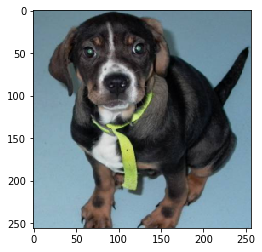

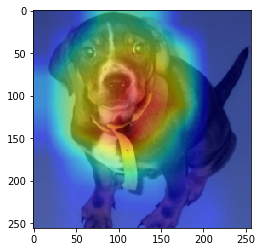

In [50]:
cats = glob.glob('test_set/test_set/cats/*.jpg')
dogs = glob.glob('test_set/test_set/dogs/*.jpg')
img = Image.open(dogs[33])#適当に選ぶ
img = transform(img)
original_img = img  #最後に表示する用
img = img.unsqueeze(0)
model = model.to(device)
model.eval()
img = img.to(device)
output = model(img)
class_label = output.argmax(dim=1).item()
print(class_label)
class_score = output[0][class_label]
med_out = My_Bottleneck.get_med_out()
N, C, H, W = med_out.shape
grads = torch.autograd.grad(class_score, med_out)
w  = grads[0][0].mean(-1).mean(-1) #チャンネルごとに勾配の平均をだし、重みを算出
ans = torch.matmul(w, med_out.view(C, H*W))
ans = F.relu(ans)
ans = ans.view(H, W).cpu().detach().numpy()
ans = cv2.resize(ans, (256, 256))
plt.imshow(original_img.permute(1, 2, 0))
plt.show()
plt.imshow(original_img.permute(1, 2, 0))
plt.imshow(ans, alpha=0.5, cmap='jet')
plt.show()